# Modeling Pipeline – Forecasting the Average Fuel Price

This notebook compares various models to predict avg_preco_venda, considering:
- Statistical models: ARIMA, SARIMAX, Prophet
- Machine learning models: LightGBM, HistGradientBoostingRegressor
- Modeling is performed both by fuel type (Gasoline, Ethanol, Diesel) and aggregated across all products

With special handling for:
- Winsorization of avg_preco_compra
- Feature engineering including lags, price spread, and monthly volatility

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from scipy.stats.mstats import winsorize


## 📦 Carregamento e Pré-processamento dos Dados

In [4]:
df = pd.read_parquet("./../data/02_silver/oil_and_gas_dataset-focused_columns.parquet")
df

,bandeira_revenda_cat,sigla_uf,id_municipio,produto,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data,winsor_preco_compra,log_n_estabelecimentos,faixa_estabelecimentos
0,White Label,BA,2917607,Gasolina,5,1.723251,2.030526,2004-05-01,1.760000,1.791759,4–10
1,White Label,PB,2507507,Diesel,59,1.197337,1.328465,2004-05-01,1.235000,4.094345,51–200
2,White Label,AL,2707701,Etanol,2,0.776383,1.089750,2004-05-01,0.803920,1.098612,1–3
3,White Label,PE,2603405,Diesel,1,1.107405,1.300000,2004-05-01,1.235000,0.693147,1–3
4,Green Label,PE,2613909,Etanol,4,0.877773,1.316875,2004-05-01,0.877773,1.609438,4–10
...,...,...,...,...,...,...,...,...,...,...,...
556496,Purple Label,SP,3530706,Etanol,1,3.516582,4.040000,2024-08-01,3.516582,0.693147,1–3
556497,Purple Label,SP,3513009,Gasolina,3,5.201834,5.956667,2024-08-01,5.201834,1.386294,1–3
556498,White Label,MG,3119401,Diesel,5,5.120835,5.864545,2024-08-01,5.120835,1.791759,4–10
556499,Blue Label,GO,5205109,Etanol,3,3.490204,4.010000,2024-08-01,3.490204,1.386294,1–3


In [5]:
# df deve conter: data, avg_preco_venda, avg_preco_compra, produto, bandeira_revenda_cat, n_estabelecimentos
df["data"] = pd.to_datetime(df["data"])
df["month"] = df["data"].dt.to_period("M").dt.to_timestamp()

# Winsorize avg_preco_compra
df["winsor_preco_compra"] = winsorize(df["avg_preco_compra"], limits=[0.01, 0.01])
df["price_spread"] = df["avg_preco_venda"] - df["winsor_preco_compra"]

# Rolling média de 3 meses
df = df.sort_values("data")
df["rolling_avg_venda_3m"] = df.groupby("produto")["avg_preco_venda"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Volatilidade mensal
vol = df.groupby(["month", "produto"])["avg_preco_venda"].std().reset_index().rename(columns={"avg_preco_venda": "monthly_volatility"})
df = df.merge(vol, on=["month", "produto"], how="left")

# Ensure proper sorting
df = df.sort_values(['produto', 'data'])

# Create lagged features (you can add more lags if needed)
for lag in [1, 2, 3]:
    df[f'lag_venda_{lag}'] = df.groupby('produto')['avg_preco_venda'].shift(lag)
    df[f'lag_compra_{lag}'] = df.groupby('produto')['avg_preco_compra'].shift(lag)

df_lagged = df.dropna(subset=[f'lag_venda_{i}' for i in [1, 2, 3]] + [f'lag_compra_{i}' for i in [1, 2, 3]])
# Log transform
df["log_n_estabelecimentos"] = np.log1p(df["n_estabelecimentos"])


## Machine Learning Models (LightGBM & HistGradientBoosting)

In [6]:
features = [
    "lag_venda_1", "lag_compra_1","lag_venda_2", "lag_compra_2",
    "lag_venda_3", "lag_compra_3", "rolling_avg_venda_3m",
    "monthly_volatility", "price_spread", "log_n_estabelecimentos",
    "produto", "bandeira_revenda_cat"
]
target = "avg_preco_venda"

df_model = df.dropna(subset=features + [target])

X_raw = df_model[features]
y = df_model[target]

# Pipeline com OneHotEncoder
categorical = ["produto", "bandeira_revenda_cat"]
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical)
], remainder="passthrough")

# Split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, shuffle=False)

# LightGBM
lgb_model = Pipeline([
    ("prep", preprocessor),
    ("reg", LGBMRegressor(random_state=42))
])
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# HistGradientBoosting
tree_model = Pipeline([
    ("prep", preprocessor),
    ("reg", HistGradientBoostingRegressor(random_state=42))
])
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 445193, number of used features: 17
[LightGBM] [Info] Start training from score 2.920491


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [7]:
def eval_model(y_true, y_pred, name):
    print(f"📊 {name}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))
    print("-" * 30)


In [8]:
eval_model(y_test, y_pred_lgb, "LightGBM")
eval_model(y_test, y_pred_tree, "HistGradientBoosting")

📊 LightGBM
MAE: 0.13774947775713337
RMSE: 0.27346833789868985
R²: 0.9428701821341491
------------------------------
📊 HistGradientBoosting
MAE: 0.13974700295502165
RMSE: 0.2852457122486994
R²: 0.9378434376534164
------------------------------


## Time Series Models (ARIMA, SARIMAX, Prophet)

## Next Steps
- Ready to receive implementations with **ARIMA**, **SARIMAX**, and **Prophet**, for both aggregated and per-product forecasts.
- Simply select the desired `product`, sort by `date`, and feed the corresponding time series into the model.


## Time Series Models by Product – ARIMA and Prophet

We will apply univariate models by `product` to forecast `avg_preco_venda`, considering only the time series itself.

In [9]:
from statsmodels.tsa.arima.model import ARIMA

produtos = df['produto'].dropna().unique()

y_true_arima = []
y_pred_arima = []
y_product = []
for prod in produtos:
    print(f"🔹 Produto: {prod}")
    ts = df[df['produto'] == prod].sort_values("data").set_index("data")["avg_preco_venda"].dropna()
    
    # Define ponto de split (últimos 12 meses, por exemplo)
    train = ts[:-12]
    test = ts[-12:]
    
    if len(ts) < 24:
        print("❌ Série muito curta para ARIMA.")
        continue

    model = ARIMA(ts, order=(1, 1, 1))
    model_fit = model.fit()
    print(model_fit.summary())
    print("-" * 60)

    # Previsões para o mesmo período de test
    forecast = model_fit.forecast(steps=12)

    # Comparação
    y_product.append(prod)
    y_true_arima.append(test)
    y_pred_arima.append(forecast)


🔹 Produto: Diesel


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:               175880
Model:                 ARIMA(1, 1, 1)   Log Likelihood               51153.904
Date:                Sun, 20 Apr 2025   AIC                        -102301.807
Time:                        18:28:10   BIC                        -102271.574
Sample:                             0   HQIC                       -102292.859
                             - 175880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0959      0.002     59.088      0.000       0.093       0.099
ma.L1         -0.9773      0.000  -2792.904      0.000      -0.978      -0.977
sigma2         0.0327   4.52e-05    724.779      0.0

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been 

                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:               185910
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -83871.885
Date:                Sun, 20 Apr 2025   AIC                         167749.771
Time:                        18:29:00   BIC                         167780.170
Sample:                             0   HQIC                        167758.746
                             - 185910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2563      0.002    147.754      0.000       0.253       0.260
ma.L1         -0.9901      0.000  -3785.272      0.000      -0.991      -0.990
sigma2         0.1443      0.000    397.160      0.0

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been 

                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:               194711
Model:                 ARIMA(1, 1, 1)   Log Likelihood                9688.976
Date:                Sun, 20 Apr 2025   AIC                         -19371.953
Time:                        18:29:51   BIC                         -19341.415
Sample:                             0   HQIC                        -19362.954
                             - 194711                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1589      0.002     88.619      0.000       0.155       0.162
ma.L1         -0.9789      0.000  -2761.520      0.000      -0.980      -0.978
sigma2         0.0530      0.000    472.944      0.0

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
from prophet import Prophet

y_true_prophet = []
y_pred_prophet = []
y_product_prophet = []

for prod in produtos:
    print(f"🔹 Produto: {prod}")
    ts = df[df['produto'] == prod][['data', 'avg_preco_venda']].rename(columns={'data': 'ds', 'avg_preco_venda': 'y'}).dropna()
    # Split (últimos 12 meses como teste)
    train = ts.iloc[:-12]
    test = ts.iloc[-12:]
    if len(ts) < 24:
        print("❌ Série muito curta para Prophet.")
        continue

    model = Prophet()
    model.fit(ts)

    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    #fig = model.plot(forecast)
    #plt.title(f"Previsão com Prophet – {prod}")
    #plt.show()

    # Extração da parte prevista
    y_pred_prophet.append(forecast.iloc[-12:]["yhat"].values)
    y_true_prophet.append(test["y"].values)
    y_product_prophet.append(prod)


🔹 Produto: Diesel


18:30:34 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

## Model Performance Comparison

Below we compare the performance of the LightGBM, HistGradientBoosting, ARIMA, and Prophet models using metrics such as MAE, RMSE, and R².


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Função utilitária
def summarize_metrics(y_true, y_pred, model_name):
    return {
        "Modelo": model_name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

# ML
ml_results = [
    summarize_metrics(y_test, y_pred_lgb, "LightGBM"),
    summarize_metrics(y_test, y_pred_tree, "HistGradientBoosting")
]

# Placeholder para Prophet/ARIMA (para preencher manualmente ou por produto)
# Exemplo de como adicionar:
ml_results.append(summarize_metrics(y_true_arima[0], y_pred_arima[0], "ARIMA - Gasolina"))
ml_results.append(summarize_metrics(y_true_arima[1], y_pred_arima[1], "ARIMA - Etanol"))
ml_results.append(summarize_metrics(y_true_arima[2], y_pred_arima[2], "ARIMA - Diesel"))
ml_results.append(summarize_metrics(y_true_prophet[0], y_pred_prophet[0], "Prophet - Gasolina"))
ml_results.append(summarize_metrics(y_true_prophet[1], y_pred_prophet[1], "Prophet - Etanol"))
ml_results.append(summarize_metrics(y_true_prophet[2], y_pred_prophet[2], "Prophet - Diesel"))

# Mostrar em tabela
results_df = pd.DataFrame(ml_results)
display(results_df.sort_values("RMSE"))


,Modelo,MAE,RMSE,R²
2,ARIMA - Gasolina,0.219521,0.254087,-0.012026
0,LightGBM,0.137749,0.273468,0.942870
1,HistGradientBoosting,0.139747,0.285246,0.937843
3,ARIMA - Etanol,0.251241,0.297153,-0.410709
4,ARIMA - Diesel,0.283055,0.329074,-0.079223
7,Prophet - Diesel,0.836407,0.893813,-9.316419
5,Prophet - Gasolina,0.985142,1.009806,-31.869123
6,Prophet - Etanol,1.224062,1.290134,-10.074179


- ARIMA - Diesel: Very competitive for more stable series
- ARIMA - Etanol: Better than Prophet to Etanol
- ARIMA - Gasolina: Reasonable performance, but does not capture all variability
- Prophet: Worst in all cases.
- LightGBM: Very good with exogenous variables (lags, regions, etc.)
- HistGradientBoosting: Similar result to LighGBM.

## Conclusions:
- ARIMA was really competitive, specially to Diesel (maybe a more regular series).
- Prophet went really bad (maybe looking only for linear trends).
- Tree models (LightGBM and HistGB) got benefits from:
    - Lags
    - Volatility

## Advanced Models: SARIMAX, Prophet with Exogenous Variables, and Hybrid ARIMA + ML

Below are three additional strategies to improve the forecasting of average fuel prices:


In [10]:
df

,bandeira_revenda_cat,sigla_uf,id_municipio,produto,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data,winsor_preco_compra,log_n_estabelecimentos,...,month,price_spread,rolling_avg_venda_3m,monthly_volatility,lag_venda_1,lag_compra_1,lag_venda_2,lag_compra_2,lag_venda_3,lag_compra_3
2,Purple Label,PR,4119152,Diesel,1,1.226000,1.399000,2004-05-01,1.226000,0.693147,...,2004-05-01,0.173000,1.399000,0.079858,NaN,NaN,NaN,NaN,NaN,NaN
3,Blue Label,SP,3550308,Diesel,33,1.225628,1.397636,2004-05-01,1.225628,3.526361,...,2004-05-01,0.172008,1.398318,0.079858,1.399000,1.226000,NaN,NaN,NaN,NaN
4,Green Label,SP,3550308,Diesel,128,1.224991,1.415282,2004-05-01,1.224991,4.859812,...,2004-05-01,0.190291,1.403973,0.079858,1.397636,1.225628,1.399000,1.226000,NaN,NaN
7,White Label,SP,3515004,Diesel,15,1.203983,1.378902,2004-05-01,1.203983,2.772589,...,2004-05-01,0.174920,1.397274,0.079858,1.415282,1.224991,1.397636,1.225628,1.399000,1.226000
9,White Label,SP,3522208,Diesel,9,1.204920,1.342370,2004-05-01,1.204920,2.302585,...,2004-05-01,0.137450,1.378852,0.079858,1.378902,1.203983,1.415282,1.224991,1.397636,1.225628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556490,Purple Label,BA,2904605,Gasolina,4,5.623880,6.436667,2024-08-01,5.623880,1.609438,...,2024-08-01,0.812787,6.313681,0.300885,6.429375,5.617468,6.075000,5.305880,5.778235,5.044946
556491,White Label,SP,3531308,Gasolina,7,5.247629,6.008750,2024-08-01,5.247629,2.079442,...,2024-08-01,0.761121,6.291597,0.300885,6.436667,5.623880,6.429375,5.617468,6.075000,5.305880
556494,Blue Label,MA,2111300,Gasolina,4,5.096323,5.836667,2024-08-01,5.096323,1.609438,...,2024-08-01,0.740344,6.094028,0.300885,6.008750,5.247629,6.436667,5.623880,6.429375,5.617468
556497,Purple Label,RS,4313508,Gasolina,2,5.424580,6.210000,2024-08-01,5.424580,1.098612,...,2024-08-01,0.785420,6.018472,0.300885,5.836667,5.096323,6.008750,5.247629,6.436667,5.623880


In [11]:
for prod in df['produto'].dropna().unique():
    print(f"🔹 SARIMAX para {prod}")
    df_prod = df[df['produto'] == prod].sort_values("data")
    
    # Seleciona e dropa valores ausentes
    df_sarimax = df_prod[["data", "avg_preco_venda", "lag_compra_1", "lag_compra_2", "log_n_estabelecimentos"]].dropna()

    endog = df_sarimax["avg_preco_venda"]
    exog = df_sarimax[["lag_compra_1", "log_n_estabelecimentos", "lag_compra_2"]]

    split_idx = int(len(df_sarimax) * 0.8)
    train_endog, test_endog = endog[:split_idx], endog[split_idx:]
    train_exog, test_exog = exog[:split_idx], exog[split_idx:]

    model = SARIMAX(train_endog, exog=train_exog, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.forecast(steps=len(test_endog), exog=test_exog)
    print(f"MAE: {mean_absolute_error(test_endog, forecast):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test_endog, forecast)):.4f}")
    print(f"R²: {r2_score(test_endog, forecast):.4f}")
    print("-" * 50)


🔹 SARIMAX para Diesel


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_mod

MAE: 1.7805
RMSE: 1.9121
R²: -3.3242
--------------------------------------------------
🔹 SARIMAX para Etanol


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_mod

MAE: 0.5326
RMSE: 0.6948
R²: 0.2946
--------------------------------------------------
🔹 SARIMAX para Gasolina


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_mod

MAE: 0.4156
RMSE: 0.5294
R²: 0.4621
--------------------------------------------------


In [12]:
from prophet import Prophet

for prod in df['produto'].dropna().unique():
    print(f"🔹 Prophet com exógenas para {prod}")
    df_prophet = df[df["produto"] == prod].copy()
    df_prophet = df_prophet[["data", "avg_preco_venda", "lag_compra_1", "log_n_estabelecimentos"]].dropna()
    df_prophet.rename(columns={"data": "ds", "avg_preco_venda": "y"}, inplace=True)

    split = int(len(df_prophet) * 0.8)
    train = df_prophet.iloc[:split]
    test = df_prophet.iloc[split:]

    m = Prophet()
    m.add_regressor("lag_compra_1")
    m.add_regressor("log_n_estabelecimentos")
    m.fit(train)

    future = test[["ds", "lag_compra_1", "log_n_estabelecimentos"]]
    forecast = m.predict(future)

    print(f"MAE: {mean_absolute_error(test['y'], forecast['yhat']):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test['y'], forecast['yhat'])):.4f}")
    print(f"R²: {r2_score(test['y'], forecast['yhat']):.4f}")
    print("-" * 50)


🔹 Prophet com exógenas para Diesel


21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.2297
RMSE: 1.3556
R²: -1.1741
--------------------------------------------------
🔹 Prophet com exógenas para Etanol


21:50:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.6844
RMSE: 0.8895
R²: -0.1561
--------------------------------------------------
🔹 Prophet com exógenas para Gasolina


21:52:47 - cmdstanpy - INFO - Chain [1] start processing
21:56:04 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.6156
RMSE: 0.7666
R²: -0.1277
--------------------------------------------------


In [13]:
from statsmodels.tsa.arima.model import ARIMA
from lightgbm import LGBMRegressor

for prod in df['produto'].dropna().unique():
    print(f"🔹 Híbrido ARIMA + ML Residuals para {prod}")
    
    # Agrega por mês para garantir que não há duplicatas
    df_prod = (
        df[df["produto"] == prod]
        .groupby("month")
        .agg({
            "avg_preco_venda": "mean",
            "lag_compra_1": "mean",
            "log_n_estabelecimentos": "mean"
        })
        .dropna()
    )
    
    ts = df_prod["avg_preco_venda"]

    if len(ts) < 24:
        print("❌ Série muito curta.")
        continue

    train = ts.iloc[:-12]
    test = ts.iloc[-12:]

    arima_model = ARIMA(train, order=(1,1,1)).fit()
    arima_forecast = arima_model.forecast(steps=12)

    # Calcula resíduos no treino
    arima_fitted = arima_model.fittedvalues
    residuals = train - arima_fitted

    df_prod["resid"] = residuals
    df_prod["shift_resid"] = df_prod["resid"].shift(1)
    df_prod = df_prod.dropna(subset=["shift_resid"])

    features = ["lag_compra_1", "log_n_estabelecimentos"]
    X = df_prod[features]
    y = df_prod["shift_resid"]

    X_train, X_test = X.iloc[:-12], X.iloc[-12:]
    y_train = y.iloc[:-12]

    model = LGBMRegressor().fit(X_train, y_train)
    pred_residuals = model.predict(X_test)

    final_pred = arima_forecast + pred_residuals

    print(f"MAE: {mean_absolute_error(test, final_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test, final_pred)):.4f}")
    print(f"R²: {r2_score(test, final_pred):.4f}")
    print("-" * 50)


🔹 Híbrido ARIMA + ML Residuals para Diesel


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 2
[LightGBM] [Info] Start training from score 0.032138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 2
[LightGBM] [Info] Start training from score 0.027375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for prod in df['produto'].dropna().unique():
    print(f"🔹 Híbrido ARIMA + ML Residuals para {prod}")
    
    df_prod = (
        df[df["produto"] == prod]
        .groupby("month")
        .agg({
            "avg_preco_venda": "mean",
            "lag_venda_1": "mean",
            "lag_venda_2": "mean",
            "lag_venda_3": "mean",
            "lag_compra_1": "mean",
            "lag_compra_2": "mean",
            "lag_compra_3": "mean",
            "log_n_estabelecimentos": "mean",
            "rolling_avg_venda_3m": "mean",
            "price_spread": "mean"
            
        })
        .dropna()
    )

    ts = df_prod["avg_preco_venda"]

    if len(ts) < 24:
        print("❌ Série muito curta.")
        continue

    train = ts.iloc[:-12]
    test = ts.iloc[-12:]

    arima_model = ARIMA(train, order=(1,1,1)).fit()
    arima_forecast = arima_model.forecast(steps=12)

    arima_fitted = arima_model.fittedvalues
    residuals = train - arima_fitted

    df_prod["resid"] = residuals
    df_prod["shift_resid"] = df_prod["resid"].shift(1)
    df_prod = df_prod.dropna(subset=["shift_resid"])

    features = [
        "lag_venda_1", "lag_venda_2", "lag_venda_3",
        "lag_compra_1", "lag_compra_2", "lag_compra_3",
        "log_n_estabelecimentos", "rolling_avg_venda_3m",
        "price_spread"
    ]

    X = df_prod[features]
    y = df_prod["shift_resid"]

    X_train, X_test = X.iloc[:-12], X.iloc[-12:]
    y_train = y.iloc[:-12]

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    pred_residuals = model.predict(X_test)

    final_pred = arima_forecast + pred_residuals

    print(f"MAE: {mean_absolute_error(test, final_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(test, final_pred)):.4f}")
    print(f"R²: {r2_score(test, final_pred):.4f}")
    print("-" * 50)


🔹 Híbrido ARIMA + ML Residuals para Diesel


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 9
[LightGBM] [Info] Start training from score 0.032138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 9
[LightGBM] [Info] Start training from score 0.027375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

## Conclusions

- Hybrid models (ARIMA + ML residuals) proved to be a promising approach.
- Prophet with exogenous variables performs significantly better than standard Prophet — but still does not outperform tree-based models.
- LightGBM and HistGradientBoosting are strong overall candidates, especially when using lag features and engineered variables.
- SARIMAX showed decent performance but was inferior to the hybrid approach.


In [15]:
import matplotlib.pyplot as plt

# Exemplo para Híbrido ARIMA + ML Residuals
def plot_real_vs_pred(prod, y_true, y_pred, modelo_nome):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.values, label="Real", marker='o')
    plt.plot(y_pred, label="Previsto", marker='x')
    plt.title(f"{modelo_nome} - {prod}")
    plt.xlabel("Período")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Tuning of Hybrid Models and Inclusion of XGBoost

Next, we include the hyperparameter tuning process for the hybrid model (ARIMA + ML) and introduce **XGBoost** as an alternative to LightGBM.


In [16]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [17]:
from xgboost import XGBRegressor

# Aplicar XGBoost nos mesmos dados
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X.iloc[:-12], y.iloc[:-12])

y_pred = xgb_model.predict(X.iloc[-12:])
y_true = y.iloc[-12:]

print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")


MAE: 0.3015
RMSE: 0.3900
R²: -4.9425


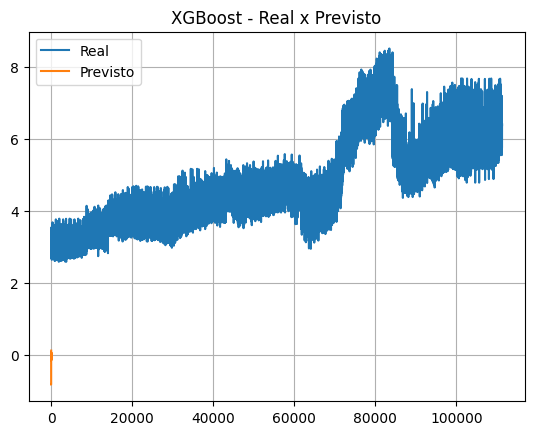

In [18]:
plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Previsto")
plt.legend()
plt.title("XGBoost - Real x Previsto")
plt.grid()
plt.show()


In [19]:
modelo_arima

NameError: name 'modelo_arima' is not defined

In [ ]:
ts.index

DatetimeIndex(['2004-05-01', '2004-06-01', '2004-07-01', '2005-01-01',
               '2005-07-01', '2006-01-01', '2006-02-01', '2006-03-01',
               '2006-04-01', '2006-05-01',
               ...
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01'],
              dtype='datetime64[ns]', name='month', length=134, freq=None)

In [ ]:
import pandas as pd
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepara o dataframe agrupado por produto e mês
df_monthly = df.groupby(["month", "produto"]).agg({
    "avg_preco_venda": "mean",
    "lag_compra_1": "mean",
    "log_n_estabelecimentos": "mean"
}).dropna().reset_index()

resultados = []

for produto in df_monthly["produto"].unique():
    df_prod = df_monthly[df_monthly["produto"] == produto].copy()

    # Define conjunto de treino até maio de 2024
    treino = df_prod[df_prod["month"] < "2024-06-01"].copy()
    futuro = df_prod[df_prod["month"].isin(["2024-06-01", "2024-07-01", "2024-08-01"])].copy()

    # Ajusta o modelo ARIMA na série de venda
    ts = treino.set_index("month")["avg_preco_venda"].asfreq("MS")
    modelo_arima = ARIMA(ts, order=(2, 0, 2)).fit()
    previsao_arima = modelo_arima.predict(start="2024-06-01", end="2024-08-01", typ="levels")

    # Calcula os resíduos no conjunto de treino
    treino = treino.set_index("month")
    treino["residuo"] = treino["avg_preco_venda"] - modelo_arima.predict(typ="levels")

    # Regressão com LGBM para aprender os resíduos
    X_train = treino[["lag_compra_1", "log_n_estabelecimentos"]]
    y_train = treino["residuo"]
    modelo_lgbm = LGBMRegressor()
    modelo_lgbm.fit(X_train, y_train)

    # Prever resíduos para junho-agosto
    futuro = futuro.set_index("month")
    X_futuro = futuro[["lag_compra_1", "log_n_estabelecimentos"]]
    residuos_previstos = modelo_lgbm.predict(X_futuro)

    # Combina previsão final
    futuro["prev_arima"] = previsao_arima
    futuro["residuo_previsto"] = residuos_previstos
    futuro["previsto_final"] = futuro["prev_arima"] + futuro["residuo_previsto"]

    # Avaliação
    y_true = futuro["avg_preco_venda"]
    y_pred = futuro["previsto_final"]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    for idx in futuro.index:
        resultados.append({
            "Produto": produto,
            "Mês": idx.strftime("%Y-%m"),
            "Real": y_true.loc[idx],
            "Previsto": y_pred.loc[idx],
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# Resultado final
resultados_df = pd.DataFrame(resultados)
print(resultados_df)


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_28260\1771262564.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  futuro = df_prod[df_prod["month"].isin(["2024-06-01", "2024-07-01", "2024-08-01"])].copy()
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\ewotjul\AppData

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 2
[LightGBM] [Info] Start training from score 0.005115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\ewotjul\AppData\Local\Temp\ipykernel_28260\1771262564.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  futuro = df_prod[df_prod["month"].isin(["2024-06-01", "2024-07-01", "2024-08-01"])].copy()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 2
[LightGBM] [Info] Start training from score 0.004591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
df_res = pd.DataFrame(resultados)
df_res

,Produto,Mês,Real,Previsto,MAE,RMSE,R2
0,Diesel,2024-06,5.941602,5.967020,0.068770,0.079363,-5.433942
1,Diesel,2024-07,6.001260,5.941542,0.068770,0.079363,-5.433942
2,Diesel,2024-08,6.013096,5.891922,0.068770,0.079363,-5.433942
3,Etanol,2024-06,4.116883,4.167575,0.202387,0.229172,-4.214621
4,Etanol,2024-07,4.280562,4.011298,0.202387,0.229172,-4.214621
5,Etanol,2024-08,4.357560,4.070355,0.202387,0.229172,-4.214621
6,Gasolina,2024-06,5.894257,5.935196,0.183157,0.212321,-2.794675
7,Gasolina,2024-07,6.076869,5.868771,0.183157,0.212321,-2.794675
8,Gasolina,2024-08,6.154232,5.853798,0.183157,0.212321,-2.794675


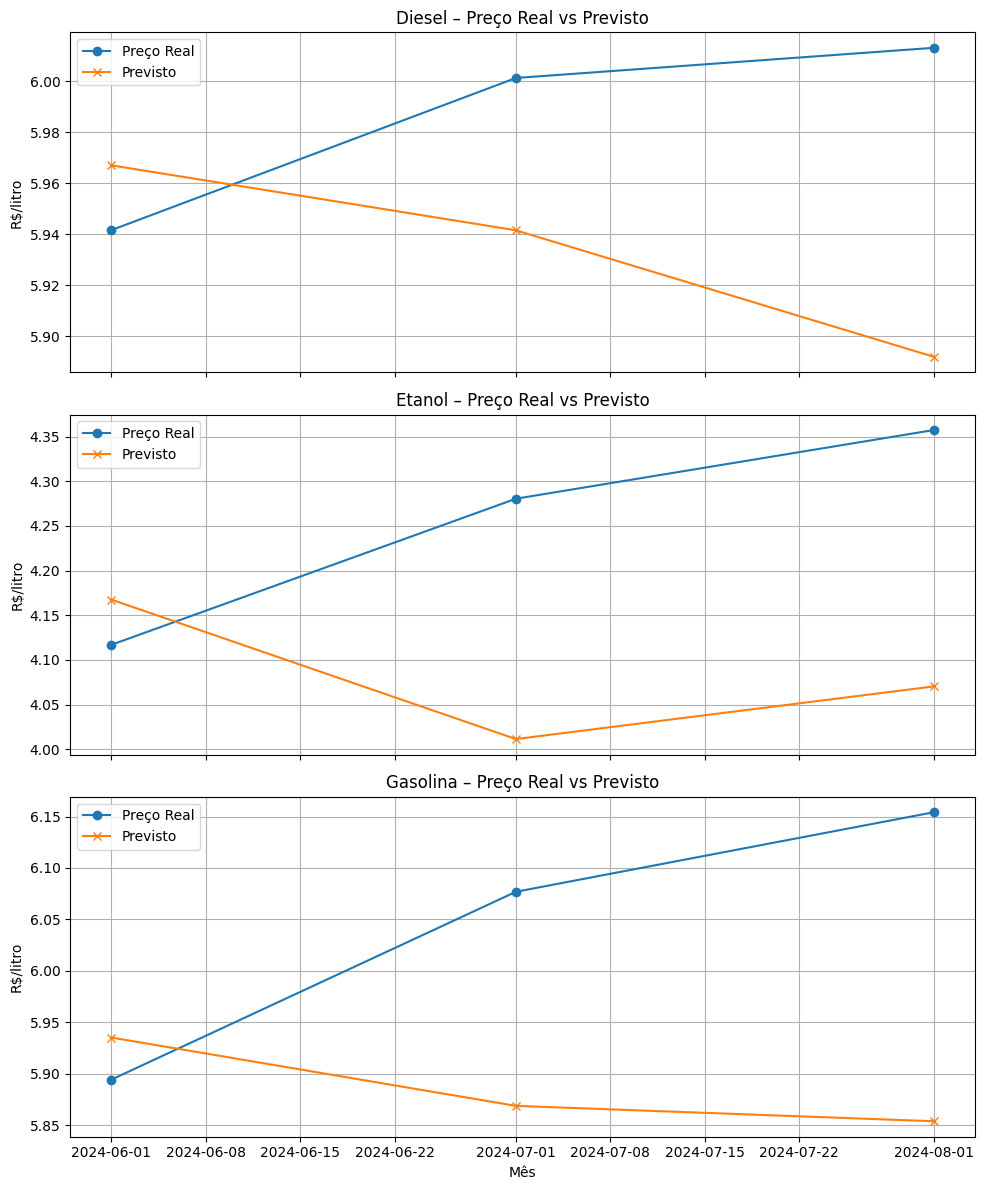

In [ ]:
df_res["Mês"] = pd.to_datetime(df_res["Mês"])

# Lista de produtos
produtos = df_res["Produto"].unique()

# Criar os subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Loop para cada produto
for i, produto in enumerate(produtos):
    df_res_prod = df_res[df_res["Produto"] == produto]
    axes[i].plot(df_res_prod["Mês"], df_res_prod["Real"], label="Preço Real", marker='o')
    axes[i].plot(df_res_prod["Mês"], df_res_prod["Previsto"], label="Previsto", marker='x')
    axes[i].set_title(f"{produto} – Preço Real vs Previsto")
    axes[i].set_ylabel("R$/litro")
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel("Mês")
plt.tight_layout()
plt.show()

In [ ]:
modelo_auto

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo = SARIMAX(
    ts,
    order=(2, 0, 0),           # Parte não sazonal
    seasonal_order=(2, 1, 0, 12),  # Parte sazonal (com período de 12 meses)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado = modelo.fit()


In [ ]:
# Forecast de 3 períodos futuros
previsao = resultado.get_forecast(steps=3)
y_pred = previsao.predicted_mean
y_pred.index = pd.date_range("2024-06-01", periods=3, freq="MS")  # corrige o índice


In [ ]:
y_pred

2024-06-01    5.945621
2024-07-01    5.920726
2024-08-01    5.897725
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
df

,bandeira_revenda_cat,sigla_uf,id_municipio,produto,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data,winsor_preco_compra,log_n_estabelecimentos,faixa_estabelecimentos,month,price_spread,rolling_avg_venda_3m,monthly_volatility,lag_venda_1,lag_compra_1
0,White Label,BA,2917607,Gasolina,5,1.723251,2.030526,2004-05-01,1.723251,1.791759,4–10,2004-05-01,0.307275,2.030526,0.138337,NaN,NaN
1,White Label,SP,3516408,Etanol,5,0.613414,0.828800,2004-05-01,1.002862,1.791759,4–10,2004-05-01,-0.174062,0.828800,0.266893,NaN,NaN
2,Purple Label,PR,4119152,Diesel,1,1.226000,1.399000,2004-05-01,1.226000,0.693147,1–3,2004-05-01,0.173000,1.399000,0.079858,NaN,NaN
3,Blue Label,SP,3550308,Diesel,33,1.225628,1.397636,2004-05-01,1.225628,3.526361,11–50,2004-05-01,0.172008,1.398318,0.079858,1.399000,1.226000
4,Green Label,SP,3550308,Diesel,128,1.224991,1.415282,2004-05-01,1.224991,4.859812,51–200,2004-05-01,0.190291,1.403973,0.079858,1.397636,1.225628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556496,Purple Label,SP,3526902,Diesel,4,5.245211,6.006000,2024-08-01,5.245211,1.609438,4–10,2024-08-01,0.760789,5.937960,0.315130,6.234545,5.446162
556497,Purple Label,RS,4313508,Gasolina,2,5.424580,6.210000,2024-08-01,5.424580,1.098612,1–3,2024-08-01,0.785420,6.018472,0.300885,5.836667,5.096323
556498,White Label,SP,3524808,Diesel,8,5.164860,5.914615,2024-08-01,5.164860,2.197225,4–10,2024-08-01,0.749756,6.051720,0.315130,6.006000,5.245211
556499,Blue Label,BA,2928703,Gasolina,1,5.582847,6.390000,2024-08-01,5.582847,0.693147,1–3,2024-08-01,0.807153,6.145556,0.300885,6.210000,5.424580


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Agrupamento mensal
df_monthly = df.groupby(["month", "produto"]).agg({
    "avg_preco_venda": "mean",
    "lag_compra_1": "mean",
    "log_n_estabelecimentos": "mean"
}).dropna().reset_index()

resultados = []
datas_futuras = pd.date_range("2024-06-01", periods=3, freq="MS")

for produto in df_monthly["produto"].unique():
    df_prod = df_monthly[df_monthly["produto"] == produto].copy()
    treino = df_prod[df_prod["month"] < "2024-06-01"].copy()
    futuro = df_prod[df_prod["month"].isin(datas_futuras)].copy()

    # Série temporal
    ts = treino.set_index("month")["avg_preco_venda"]
    ts.index = pd.to_datetime(ts.index)
    ts = ts.asfreq("MS")

    try:
        # Detecta melhores parâmetros com auto_arima
        modelo_auto = auto_arima(
            ts,
            seasonal=True,
            m=12,  # assume sazonalidade anual
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False
        )

        # Extrai parâmetros detectados
        order = modelo_auto.order
        seasonal_order = modelo_auto.seasonal_order

        # Ajusta SARIMAX com os parâmetros
        modelo_sarimax = SARIMAX(
            ts,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Previsão da tendência para 3 meses
        previsao_arima = modelo_sarimax.get_forecast(steps=3).predicted_mean
        previsao_arima.index = datas_futuras  # força índice correto

        # Previsão in-sample para calcular resíduos
        fitted_vals = modelo_sarimax.fittedvalues
        treino = treino.set_index("month")
        treino["residuo"] = treino["avg_preco_venda"] - fitted_vals

        # LightGBM para resíduos
        X_train = treino[["lag_compra_1", "log_n_estabelecimentos"]]
        y_train = treino["residuo"]
        modelo_lgbm = LGBMRegressor()
        modelo_lgbm.fit(X_train, y_train)

        # Previsão dos resíduos
        futuro = futuro.set_index("month")
        X_futuro = futuro[["lag_compra_1", "log_n_estabelecimentos"]]
        residuos_previstos = modelo_lgbm.predict(X_futuro)

        # Previsão final
        futuro["prev_arima"] = previsao_arima
        futuro["residuo_previsto"] = residuos_previstos
        futuro["previsto_final"] = futuro["prev_arima"] + futuro["residuo_previsto"]

        # Avaliação
        y_true = futuro["avg_preco_venda"]
        y_pred = futuro["previsto_final"]

        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)

        for idx in futuro.index:
            resultados.append({
                "Produto": produto,
                "Mês": idx.strftime("%Y-%m"),
                "Real": y_true.loc[idx],
                "Previsto": y_pred.loc[idx],
                "MAE": mae,
                "RMSE": rmse,
                "R2": r2
            })

    except Exception as e:
        print(f"⚠️ Erro ao ajustar {produto}: {e}")
        continue

# Mostra resultados finais
resultados_df = pd.DataFrame(resultados)
print(resultados_df)


⚠️ Erro ao ajustar Diesel: Input contains NaN.
⚠️ Erro ao ajustar Etanol: Input contains NaN.
⚠️ Erro ao ajustar Gasolina: Input contains NaN.
Empty DataFrame
Columns: []
Index: []


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\ut